# Telecom

## Import Packages

In [102]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_squared_log_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
import statsmodels.formula.api as smf
from sklearn.calibration import calibration_curve
from xgboost import XGBRegressor

from patsy import dmatrices, dmatrix, build_design_matrices

import math

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

## Load and Inspect the Data

In [3]:
telecom_df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

What are the columns of the dataset?

In [4]:
telecom_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

How many rows and columns do we have?

In [5]:
telecom_df.shape

(7043, 21)

In [6]:
telecom_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
def summarize_dataframe(df):
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']), 
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']), 
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])], 
                     axis=1).set_index('Variable Name')
    return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")

What are the names of the variables in the data frame? How many values are missing? Use our self defined `summarize_dataframe` function to find out the number of NA's for each variable.

In [8]:
summarize_dataframe(telecom_df)

/tmp/ipykernel_204/2366052593.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")


,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,object,0,7043,7043.0,7043,3186-AJIEK,1,,,,,,,
gender,object,0,2,7043.0,2,Male,3555,,,,,,,
SeniorCitizen,int64,0,2,7043.0,,,,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,object,0,2,7043.0,2,No,3641,,,,,,,
Dependents,object,0,2,7043.0,2,No,4933,,,,,,,
tenure,int64,0,73,7043.0,,,,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,object,0,2,7043.0,2,Yes,6361,,,,,,,
MultipleLines,object,0,3,7043.0,3,No,3390,,,,,,,
InternetService,object,0,3,7043.0,3,Fiber optic,3096,,,,,,,
OnlineSecurity,object,0,3,7043.0,3,No,3498,,,,,,,


## Engineer Features

In [9]:
telecom_df["Churn_Num"] = np.where(telecom_df['Churn']=='Yes', 1, 0)
telecom_df["TotalCharges"] = telecom_df['TotalCharges'].replace(' ',0)
telecom_df["TotalCharges"] = pd.to_numeric(telecom_df["TotalCharges"])
telecom_df["Short_Tenure"] = telecom_df["tenure"]<=6
telecom_df["LowOrHighMonthlyCharges"] = (telecom_df["MonthlyCharges"]<25) | (telecom_df["MonthlyCharges"]>65)
telecom_df["LowMonthlyCharges"] = telecom_df["MonthlyCharges"]<25
telecom_df["LogMonthlyCharges"] = np.log2(telecom_df["MonthlyCharges"])
telecom_df["HighMonthlyCharges"] = telecom_df["MonthlyCharges"]>65
summarize_dataframe(telecom_df)
telecom_df.head()

/tmp/ipykernel_204/2366052593.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Num,Short_Tenure,LowOrHighMonthlyCharges,LowMonthlyCharges,LogMonthlyCharges,HighMonthlyCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,True,False,False,4.899659,False
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0,False,False,False,5.831624,False
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,True,False,False,5.750874,False
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,False,False,False,5.402586,False
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,True,True,False,6.143638,True


In [10]:
telecom_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Num,Short_Tenure,LowOrHighMonthlyCharges,LowMonthlyCharges,LogMonthlyCharges,HighMonthlyCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,True,False,False,4.899659,False
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0,False,False,False,5.831624,False
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,True,False,False,5.750874,False
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,False,False,False,5.402586,False
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,True,True,False,6.143638,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0,False,True,False,6.405992,True
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0,False,True,False,6.689299,True
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,False,False,False,4.887525,False
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,1,True,True,False,6.217231,True


## Creating Training and Testing Sets

Once we have this, we can take all of the data before February 19, 2008 as our training set, and all of the data after that point as our testing set.

In [11]:
telecom_df_train, telecom_df_test = train_test_split(telecom_df, test_size=0.2)

## Preprocess Training and Testing Data

In [12]:
list(telecom_df_train.columns)

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'Churn_Num',
 'Short_Tenure',
 'LowOrHighMonthlyCharges',
 'LowMonthlyCharges',
 'LogMonthlyCharges',
 'HighMonthlyCharges']

From the list above, choose some independent variables to put into your models.

In [13]:
ind_var_selected = ['tenure','MultipleLines','Dependents','SeniorCitizen']
df_var_selected = ['Churn_Num','MonthlyCharges','TotalCharges','gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']
boosted_var_selected = ['Churn_Num','MonthlyCharges','TotalCharges','SeniorCitizen','Partner','Dependents','tenure','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Short_Tenure','LowMonthlyCharges','HighMonthlyCharges','LogMonthlyCharges']

In [14]:
X_train = telecom_df_train[ind_var_selected]
y_train = telecom_df_train['Churn_Num']
df_train = telecom_df_train[df_var_selected]

In [15]:
df_train_boosted = telecom_df_train[boosted_var_selected]
df_test_boosted = telecom_df_test[boosted_var_selected]

In [16]:
X_test = telecom_df_test[ind_var_selected]
y_test = telecom_df_test['Churn_Num']
df_test = telecom_df_test[df_var_selected]

## Scoring Rules and Benchmarks

In [17]:
bench_5050 = np.repeat(0.5, len(telecom_df_test))

In [18]:
log_loss(y_test, bench_5050)

0.6931471805599454

## Fit a Logistic Regression

In [19]:
lr = smf.logit(formula='Q("Churn_Num") ~ Q("tenure") + Q("MultipleLines") + Q("Dependents") + Q("SeniorCitizen")', data=telecom_df_train).fit()
lr.summary()

Optimization terminated successfully.
         Current function value: 0.480907
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         Q("Churn_Num")   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5628
Method:                           MLE   Df Model:                            5
Date:                Thu, 26 Sep 2024   Pseudo R-squ.:                  0.1719
Time:                        01:28:12   Log-Likelihood:                -2709.4
converged:                       True   LL-Null:                       -3271.9
Covariance Type:            nonrobust   LLR p-value:                5.396e-241
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -0.1860      0.058     -3.230      0.001      -0.299      -0.073
Q("MultipleLines")[T.No phone service]     0.2351      0.122      1.919      0.055      -0.005       0.475
Q("MultipleLines")[T.Yes]                  0.9199      0.078     11.782      0.000       0.767       1.073
Q("Dependents")[T.Yes]                    -0.5228      0.083     -6.300      0.000      -0.685      -0.360
Q("tenure")                               -0.0471      0.002    -25.932      0.000      -0.051      -0.044
Q("SeniorCitizen")                         0.8176      0.087      9.446      0.000       0.648       0.987
==========================================================================================================
"""

In [20]:
lr_pred = lr.predict(telecom_df_test)

In [21]:
log_loss(y_test, lr_pred)

0.4761129303453607

In [22]:
roc_auc_score(y_test, lr_pred)

0.7723487786730834

In [23]:
lr.params

Intercept                                -0.185999
Q("MultipleLines")[T.No phone service]    0.235120
Q("MultipleLines")[T.Yes]                 0.919873
Q("Dependents")[T.Yes]                   -0.522813
Q("tenure")                              -0.047090
Q("SeniorCitizen")                        0.817619
dtype: float64

## Neural Network

In [24]:
formula_binary = 'Churn_Num ~ ' + " + ".join(df_train.columns[1:3]) + " + " + 'Q("' + '") + Q("'.join(df_train.columns[3:]) + '")'

In [25]:
formula_binary

'Churn_Num ~ MonthlyCharges + TotalCharges + Q("gender") + Q("SeniorCitizen") + Q("Partner") + Q("Dependents") + Q("tenure") + Q("PhoneService") + Q("MultipleLines") + Q("InternetService") + Q("OnlineSecurity") + Q("OnlineBackup") + Q("DeviceProtection") + Q("TechSupport") + Q("StreamingTV") + Q("StreamingMovies") + Q("Contract") + Q("PaperlessBilling") + Q("PaymentMethod")'

In [26]:
y_train_linear_binary, X_train_linear_binary = dmatrices(formula_binary, df_train, return_type="dataframe")

In [27]:
y_train_linear_binary

,Churn_Num
4479,0.0
1982,0.0
2216,0.0
5432,1.0
2576,0.0
...,...
300,0.0
1383,1.0
4368,1.0
2973,1.0


In [28]:
X_train_linear_binary

,Intercept,"Q(""gender"")[T.Male]","Q(""Partner"")[T.Yes]","Q(""Dependents"")[T.Yes]","Q(""PhoneService"")[T.Yes]","Q(""MultipleLines"")[T.No phone service]","Q(""MultipleLines"")[T.Yes]","Q(""InternetService"")[T.Fiber optic]","Q(""InternetService"")[T.No]","Q(""OnlineSecurity"")[T.No internet service]","Q(""OnlineSecurity"")[T.Yes]","Q(""OnlineBackup"")[T.No internet service]","Q(""OnlineBackup"")[T.Yes]","Q(""DeviceProtection"")[T.No internet service]","Q(""DeviceProtection"")[T.Yes]","Q(""TechSupport"")[T.No internet service]","Q(""TechSupport"")[T.Yes]","Q(""StreamingTV"")[T.No internet service]","Q(""StreamingTV"")[T.Yes]","Q(""StreamingMovies"")[T.No internet service]","Q(""StreamingMovies"")[T.Yes]","Q(""Contract"")[T.One year]","Q(""Contract"")[T.Two year]","Q(""PaperlessBilling"")[T.Yes]","Q(""PaymentMethod"")[T.Credit card (automatic)]","Q(""PaymentMethod"")[T.Electronic check]","Q(""PaymentMethod"")[T.Mailed check]",MonthlyCharges,TotalCharges,"Q(""SeniorCitizen"")","Q(""tenure"")"
4479,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,24.45,1493.10,0.0,59.0
1982,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.95,268.40,0.0,14.0
2216,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,108.95,7111.30,1.0,64.0
5432,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,76.40,160.80,0.0,2.0
2576,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,108.25,5935.10,0.0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,64.90,1509.80,0.0,23.0
1383,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,49.95,49.95,0.0,1.0
4368,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,80.85,751.65,1.0,9.0
2973,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,100.15,6283.30,0.0,62.0


In [29]:
X_test_linear_binary = build_design_matrices([X_train_linear_binary.design_info], df_test, return_type="dataframe")[0]
X_test_linear_binary.shape

(1409, 31)

In [30]:
#%%time
#nn_model_binary = MLPClassifier(activation='relu', 
                              #  hidden_layer_sizes=(4,3), 
                               # alpha = .0001,
                             #   random_state=23)
#nn_model_binary.fit(X_train_linear_binary, y_train_linear_binary.values.ravel())

In [31]:
param_grid = {
    'hidden_layer_sizes': [(4,), (4, 3), (8, 4), (10, 5, 2)],  # Different hidden layer configurations
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Different alpha values for regularization
    'random_state': [23, 42, 100],  # Different random states
}

# Initialize the MLPClassifier
nn_model_binary = MLPClassifier(activation='relu')

# Initialize the grid search
grid_search = GridSearchCV(estimator=nn_model_binary, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train_linear_binary, y_train_linear_binary.values.ravel())

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

nn_model_binary.fit(X_train_linear_binary, y_train_linear_binary.values.ravel())

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptro

MLPClassifier()

In [32]:
best_score

0.8012091391502929

In [33]:
nn_pred_binary = nn_model_binary.predict_proba(X_test_linear_binary)[:,1]

In [34]:
roc_auc_score(df_test['Churn_Num'], nn_pred_binary)

0.7808009730511274

In [35]:
# Compute calibration curve for the training set
train_fraction_of_positives, train_mean_predicted_value = calibration_curve(df_train['Churn_Num'], nn_model_binary.predict_proba(X_train_linear_binary)[:,1], n_bins=10)

# Compute calibration curve for the test set
test_fraction_of_positives, test_mean_predicted_value = calibration_curve(df_test['Churn_Num'], nn_pred_binary , n_bins=10)

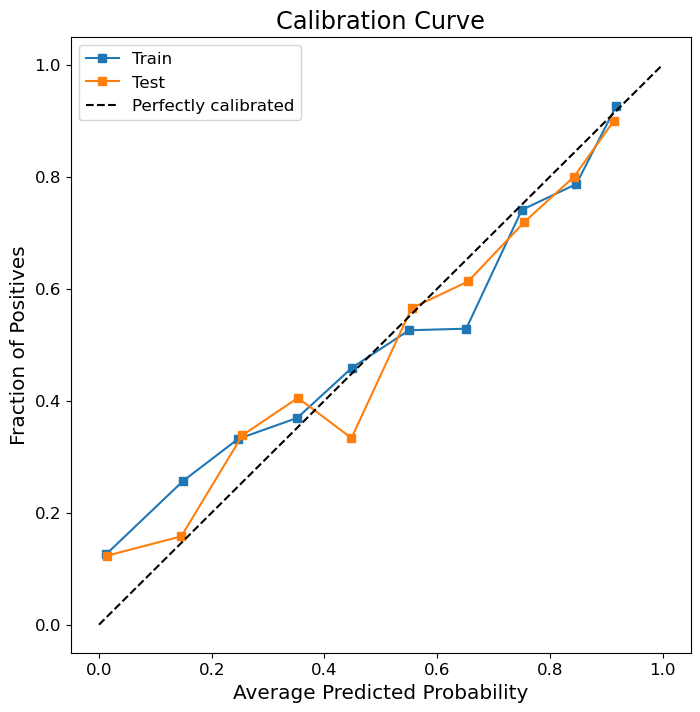

In [36]:
# Plot calibration curves
plt.figure(figsize=(8, 8))
plt.plot(train_mean_predicted_value, train_fraction_of_positives, "s-", label="Train")
plt.plot(test_mean_predicted_value, test_fraction_of_positives, "s-", label="Test")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.ylabel("Fraction of Positives")
plt.xlabel("Average Predicted Probability")
plt.legend()
plt.title("Calibration Curve")
plt.show()

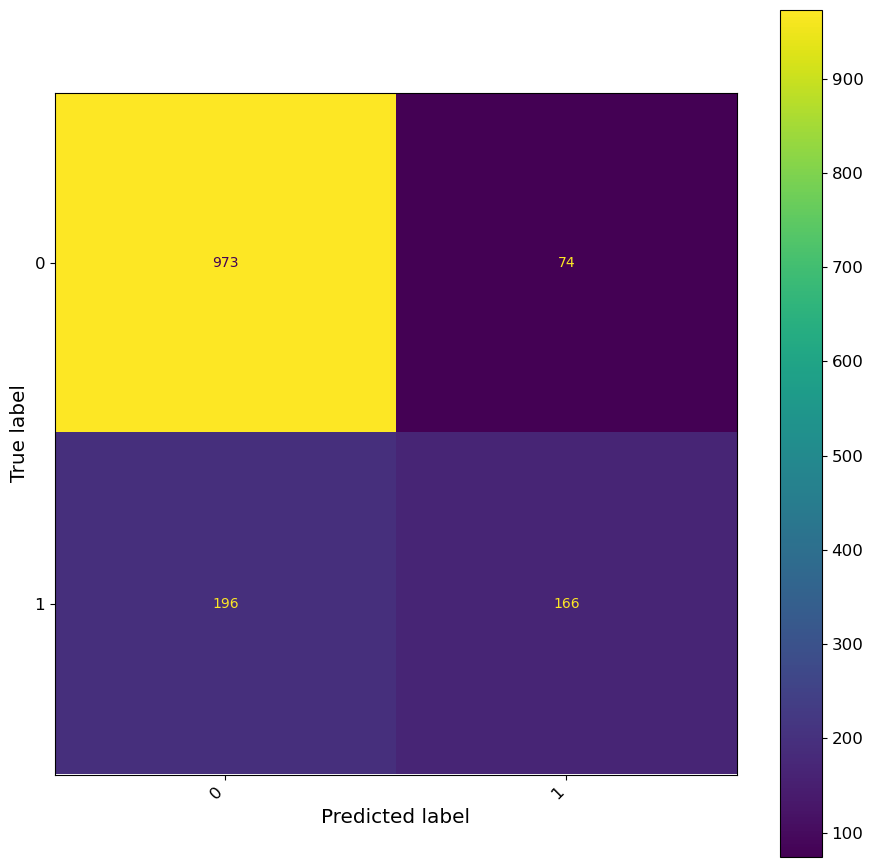

In [37]:
predictions = (nn_pred_binary > .5).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix(df_test['Churn_Num'], predictions))
disp.plot()
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [38]:
print(classification_report(df_test['Churn_Num'], (nn_pred_binary > .5).astype(int), zero_division=0))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1047
           1       0.69      0.46      0.55       362

    accuracy                           0.81      1409
   macro avg       0.76      0.69      0.71      1409
weighted avg       0.80      0.81      0.79      1409



## Boosted Tree

In [39]:
formula_binary_boosted = 'Churn_Num ~ ' + " + " + 'Q("' + '") + Q("'.join(df_train_boosted.columns[1:]) + '")'
y_train_linear_boosted, X_train_linear_boosted = dmatrices(formula_binary_boosted, df_train_boosted, return_type="dataframe")
X_train_linear_boosted
X_train_linear_boosted = X_train_linear_boosted.rename(columns={'Q("Partner")[T.Yes]': "Partner_Yes",'Q("Dependents")[T.Yes]': "Dependents_Yes",'Q("InternetService")[T.Fiber optic]': "InternetService_Fiber", 'Q("InternetService")[T.No]': "InternetService_No", 'Q("OnlineSecurity")[T.No internet service]':"OnlineSecurity_No_Internet",'Q("OnlineSecurity")[T.Yes]':"OnlineSecurity_Yes",'Q("OnlineBackup")[T.No internet service]':"OnlineBackup_No_Internet", 'Q("OnlineBackup")[T.Yes]':"OnlineBackup_Yes", 'Q("DeviceProtection")[T.No internet service]': "DeviceProtection_No_Internet", 'Q("DeviceProtection")[T.Yes]':"DeviceProtection_Yes", 'Q("TechSupport")[T.No internet service]':"TechSupport_No_Internet",'Q("TechSupport")[T.Yes]':"TechSupport_Yes", 'Q("StreamingTV")[T.No internet service]': "StreamingTV_No_Internet", 'Q("StreamingTV")[T.Yes]':"StreamingTV_Yes", 'Q("StreamingMovies")[T.No internet service]': "StreamingMovies_No_Internet", 'Q("StreamingMovies")[T.Yes]': "StreamingMovies_Yes", 'Q("Contract")[T.One year]': "Contract_One_Year", 'Q("Contract")[T.Two year]': "Contract_Two_Year", 'Q("PaperlessBilling")[T.Yes]': "PaperlessBilling_Yes", 'Q("PaymentMethod")[T.Credit card (automatic)]': "PaymentMethod_Credit_Card_Automatic", 'Q("PaymentMethod")[T.Electronic check]': "PaymentMethod_Electronic_Check", 'Q("PaymentMethod")[T.Mailed check]': "PaymentMethod_Mailed_Check", 'Q("Short_Tenure")[T.True]': "Short_Tenure_True", 'Q("LowMonthlyCharges")[T.True]': "LowMonthlyCharges_True", 'Q("HighMonthlyCharges")[T.True]': "HighMonthlyCharges_True", 'Q("MonthlyCharges")': "MonthlyCharges", 'Q("TotalCharges")': "TotalCharges", 'Q("SeniorCitizen")': "SeniorCitizen", 'Q("tenure")': "tenure", 'Q("LogMonthlyCharges")': "LogMonthlyCharges"})

In [40]:
y_test_linear_boosted, X_test_linear_boosted = dmatrices(formula_binary_boosted, df_test_boosted, return_type="dataframe")
X_test_linear_boosted = X_test_linear_boosted.rename(columns={'Q("Partner")[T.Yes]': "Partner_Yes",'Q("Dependents")[T.Yes]': "Dependents_Yes",'Q("InternetService")[T.Fiber optic]': "InternetService_Fiber", 'Q("InternetService")[T.No]': "InternetService_No", 'Q("OnlineSecurity")[T.No internet service]':"OnlineSecurity_No_Internet",'Q("OnlineSecurity")[T.Yes]':"OnlineSecurity_Yes",'Q("OnlineBackup")[T.No internet service]':"OnlineBackup_No_Internet", 'Q("OnlineBackup")[T.Yes]':"OnlineBackup_Yes", 'Q("DeviceProtection")[T.No internet service]': "DeviceProtection_No_Internet", 'Q("DeviceProtection")[T.Yes]':"DeviceProtection_Yes", 'Q("TechSupport")[T.No internet service]':"TechSupport_No_Internet",'Q("TechSupport")[T.Yes]':"TechSupport_Yes", 'Q("StreamingTV")[T.No internet service]': "StreamingTV_No_Internet", 'Q("StreamingTV")[T.Yes]':"StreamingTV_Yes", 'Q("StreamingMovies")[T.No internet service]': "StreamingMovies_No_Internet", 'Q("StreamingMovies")[T.Yes]': "StreamingMovies_Yes", 'Q("Contract")[T.One year]': "Contract_One_Year", 'Q("Contract")[T.Two year]': "Contract_Two_Year", 'Q("PaperlessBilling")[T.Yes]': "PaperlessBilling_Yes", 'Q("PaymentMethod")[T.Credit card (automatic)]': "PaymentMethod_Credit_Card_Automatic", 'Q("PaymentMethod")[T.Electronic check]': "PaymentMethod_Electronic_Check", 'Q("PaymentMethod")[T.Mailed check]': "PaymentMethod_Mailed_Check", 'Q("Short_Tenure")[T.True]': "Short_Tenure_True", 'Q("LowMonthlyCharges")[T.True]': "LowMonthlyCharges_True", 'Q("HighMonthlyCharges")[T.True]': "HighMonthlyCharges_True", 'Q("MonthlyCharges")': "MonthlyCharges", 'Q("TotalCharges")': "TotalCharges", 'Q("SeniorCitizen")': "SeniorCitizen", 'Q("tenure")': "tenure", 'Q("LogMonthlyCharges")': "LogMonthlyCharges"})
#X_test_linear_boosted = X_test_linear_boosted.rename(columns={'Q("MultipleLines")[T.No phone service]': "MultipleLines_No_Phone_Service", 'Q("MultipleLines")[T.Yes]': "MultipleLines_Yes", 'Q("Dependents")[T.Yes]': "Dependents_Yes", 'Q("tenure")': "Tenure", 'Q("SeniorCitizen")': "SeniorCitizen"})

In [41]:
X_train_linear_boosted

,Intercept,Partner_Yes,Dependents_Yes,InternetService_Fiber,InternetService_No,OnlineSecurity_No_Internet,OnlineSecurity_Yes,OnlineBackup_No_Internet,OnlineBackup_Yes,DeviceProtection_No_Internet,DeviceProtection_Yes,TechSupport_No_Internet,TechSupport_Yes,StreamingTV_No_Internet,StreamingTV_Yes,StreamingMovies_No_Internet,StreamingMovies_Yes,Contract_One_Year,Contract_Two_Year,PaperlessBilling_Yes,PaymentMethod_Credit_Card_Automatic,PaymentMethod_Electronic_Check,PaymentMethod_Mailed_Check,Short_Tenure_True,LowMonthlyCharges_True,HighMonthlyCharges_True,MonthlyCharges,TotalCharges,SeniorCitizen,tenure,LogMonthlyCharges
4479,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,24.45,1493.10,0.0,59.0,4.611763
1982,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,19.95,268.40,0.0,14.0,4.318317
2216,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,108.95,7111.30,1.0,64.0,6.767522
5432,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,76.40,160.80,0.0,2.0,6.255501
2576,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,108.25,5935.10,0.0,53.0,6.758223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,64.90,1509.80,0.0,23.0,6.020147
1383,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,49.95,49.95,0.0,1.0,5.642413
4368,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,80.85,751.65,1.0,9.0,6.337176
2973,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,100.15,6283.30,0.0,62.0,6.646019


In [82]:
xgb_model = XGBRegressor(max_depth=6,
                         n_estimators = 50,
                         learning_rate=.1,
                         random_state=201)
xgb_model.fit(X_train_linear_boosted, y_train_linear_boosted)
xgb_pred = xgb_model.predict(X_test_linear_boosted)

In [83]:
# Use the best parameters from GridSearchCV
xgb_model = XGBRegressor(max_depth=3,
                         n_estimators=50,
                         learning_rate=0.1,
                         colsample_bytree=1,
                         subsample=0.7,
                         min_child_weight=1,
                         random_state=201)

# Train the model
xgb_model.fit(X_train_linear_boosted, y_train_linear_boosted)

# Make predictions
xgb_pred = xgb_model.predict(X_test_linear_boosted)

In [84]:
def get_tree_importances(model, data):
    return pd.DataFrame({'Importance': model.feature_importances_}, index=data.columns).sort_values(['Importance'], ascending=False)

In [85]:
get_tree_importances(xgb_model, X_train_linear_boosted)

,Importance
InternetService_Fiber,0.231764
PaymentMethod_Electronic_Check,0.165263
tenure,0.109603
Contract_Two_Year,0.081443
InternetService_No,0.066586
Contract_One_Year,0.052995
PaperlessBilling_Yes,0.040968
Short_Tenure_True,0.032470
OnlineSecurity_Yes,0.031747
SeniorCitizen,0.025220


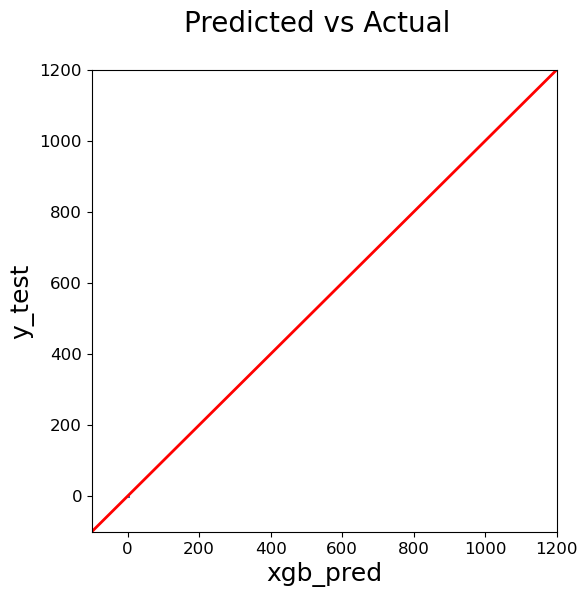

In [86]:
plt.figure(figsize=(6,6))
plt.scatter(xgb_pred, y_test_linear_boosted, s = 0.2)
plt.xlim(-100, 1200)
plt.ylim(-100, 1200)
plt.plot([-100, 1200], [-100, 1200], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('xgb_pred', fontsize=18)
plt.ylabel('y_test', fontsize=18)
plt.show()

In [103]:
def RMSLE(y_true, y_pred):
    y_pred_use = y_pred.clip(0)
    rmsle = mean_squared_log_error(y_true, y_pred_use)**(1/2)
    return rmsle

def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)],
                                  "RMSLE": [RMSLE(y_true, y_pred)]})
    display(acc_df.style.hide(axis='index'))

In [104]:
roc_auc_score(y_test_linear_boosted, xgb_pred)

0.8543074925992179